In [ ]:
from google.colab import drive
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB6


drive.mount('/content/drive')


warnings.filterwarnings("ignore")
print("Kütüphaneler yüklendi ve Drive bağlandı.")

Mounted at /content/drive
Kütüphaneler yüklendi ve Drive bağlandı.


In [ ]:
# --- VERİ YOLLARINI HAZIRLAMA ---

# Colab üzerindeki Drive yolun:
base_dir = Path('/content/drive/MyDrive/Dataset')
image_dir = base_dir / 'Training'       # Eğitim verisi yolu
test_image_dir = base_dir / 'Testing'   # Test verisi yolu

# --- EĞİTİM VERİSİ DOSYA LİSTESİ ---
filepaths = list(image_dir.glob(r"**/*.png")) + list(image_dir.glob(r"**/*.jpg"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name="filepath").astype(str)
labels = pd.Series(labels, name="label")
image_df = pd.concat([filepaths, labels], axis=1)

# --- TEST VERİSİ DOSYA LİSTESİ ---
test_filepaths = list(test_image_dir.glob(r"**/*.png")) + list(test_image_dir.glob(r"**/*.jpg"))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

test_filepaths_series = pd.Series(test_filepaths, name="filepath").astype(str)
test_labels_series = pd.Series(test_labels, name="label")
test_df = pd.concat([test_filepaths_series, test_labels_series], axis=1)

print(f"Test Kümesi Boyutu: {len(test_df)}")

# Eğitim ve Doğrulama Ayrımı
train_df, val_df = train_test_split(
    image_df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=image_df['label']
)

print(f"Eğitim Kümesi Boyutu: {len(train_df)}")
print(f"Doğrulama Kümesi Boyutu: {len(val_df)}")

Test Kümesi Boyutu: 1311
Eğitim Kümesi Boyutu: 4580
Doğrulama Kümesi Boyutu: 1146


In [ ]:
# --- GENERATOR AYARLARI ---

IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
BATCH_SIZE = 16  # Hata alırsan bunu 8 yap

print("\n--- Generator'lar Hazırlanıyor ---")

# EfficientNet önceden eğitilmiş ağırlıklarla kullanıldığı için rescale=1./255 YAPMIYORUZ.
# EfficientNet modeli veriyi kendi içinde normalize eder.

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("Eğitim verisi yükleniyor...")
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    color_mode="rgb",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Doğrulama verisi yükleniyor...")
validation_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    color_mode="rgb",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Test verisi yükleniyor...")
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


--- Generator'lar Hazırlanıyor ---
Eğitim verisi yükleniyor...
Found 4580 validated image filenames belonging to 4 classes.
Doğrulama verisi yükleniyor...
Found 1146 validated image filenames belonging to 4 classes.
Test verisi yükleniyor...
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
# ---  MODEL MİMARİSİ ---

print("--- EfficientNetB6 Modeli İndiriliyor ---")

# Base Model: ImageNet ağırlıklarıyla
base_model = EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)
)

# Transfer Learning: Temel modeli donduruyoruz
base_model.trainable = False

model = Sequential()

# Model Katmanları
model.add(base_model)
model.add(GlobalAveragePooling2D())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Çıkış Katmanı
number_of_classes = len(train_images.class_indices)
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

--- EfficientNetB6 Modeli İndiriliyor ---
165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 7, 7, 2304)     │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,256,211 (157.38 MB)

 Trainable params: 295,812 (1.13 MB)

 Non-trainable params: 40,960,399 (156.25 MB)

In [ ]:
# --- CALLBACKS VE EĞİTİM ---

MONITOR_METRIC = 'val_loss'

# Log klasörü
tensorboard_callback = TensorBoard(log_dir="logs")

reduce_lr = ReduceLROnPlateau(
    monitor=MONITOR_METRIC,
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor=MONITOR_METRIC,
    patience=8,
    verbose=1,
    restore_best_weights=True
)

# En iyi modeli kaydı
checkpoint_filepath = '/content/drive/MyDrive/CnnSavedModels/EfficientNetB6_best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=MONITOR_METRIC,
    save_best_only=True,
    verbose=1
)

my_callbacks = [tensorboard_callback, reduce_lr, early_stopping, model_checkpoint]

print("--- Model Eğitimi Başlatılıyor ---")

EPOCHS = 100

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=my_callbacks
)

--- Model Eğitimi Başlatılıyor ---
Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5915 - loss: 1.0554
Epoch 1: val_loss improved from inf to 0.49913, saving model to /content/drive/MyDrive/CnnSavedModels/EfficientNetB6_best_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 1913s 6s/step - accuracy: 0.5919 - loss: 1.0544 - val_accuracy: 0.8377 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8094 - loss: 0.5125
Epoch 2: val_loss improved from 0.49913 to 0.33413, saving model to /content/drive/MyDrive/CnnSavedModels/EfficientNetB6_best_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 89s 309ms/step - accuracy: 0.8094 - loss: 0.5124 - val_accuracy: 0.8839 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8366 - loss: 0.4441
Epoch 3: val_loss improved from 0.33413 to 0.32144, saving model to /content/drive/MyDrive/CnnSavedModels/EfficientNetB6_best_model.ke

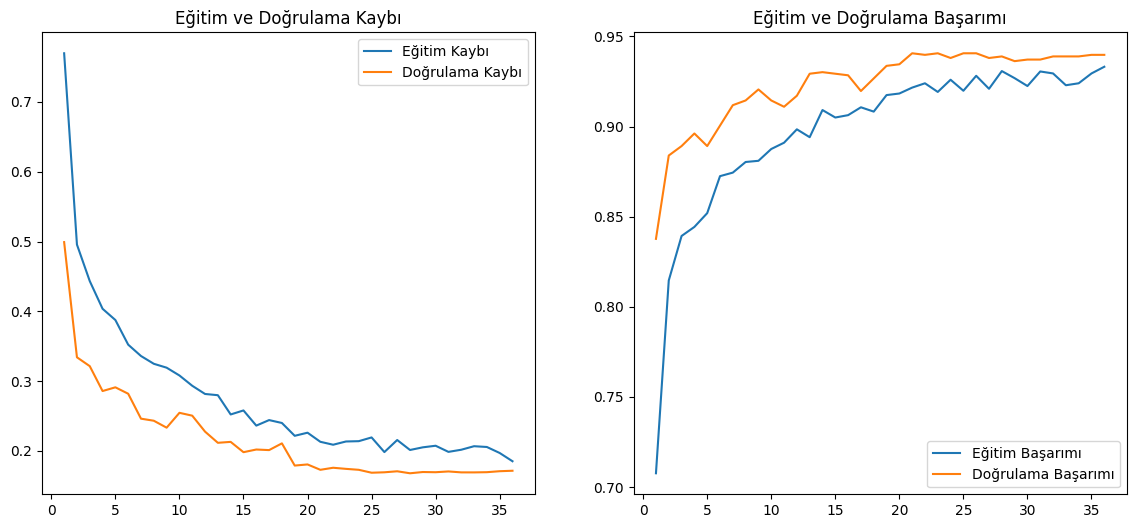


--- Test Seti Değerlendirmesi ---
82/82 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9479 - loss: 0.1250
📈 Test Kayıp:    0.1918
🎯 Test Başarım:  92.22%
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      glioma       0.95      0.84      0.89       300
  meningioma       0.83      0.87      0.85       306
     notumor       0.97      0.98      0.98       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



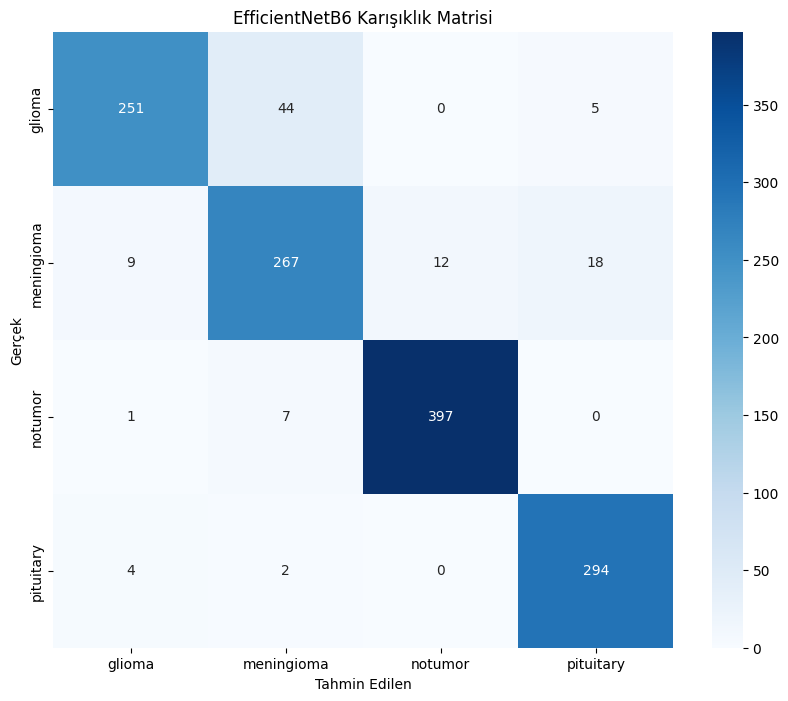

In [ ]:
# --- GÖRSELLEŞTİRME VE TEST ---

# Kayıp ve Başarım Grafikleri
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Eğitim Başarımı')
plt.plot(epochs_range, val_accuracy, label='Doğrulama Başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.legend()
plt.show()

# --- TEST SETİ DEĞERLENDİRMESİ ---
print("\n--- Test Seti Değerlendirmesi ---")
results = model.evaluate(test_images, verbose=1)
print(f"📈 Test Kayıp:    {results[0]:.4f}")
print(f"🎯 Test Başarım:  {results[1] * 100:.2f}%")

# Tahminler
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_images.classes
class_names = list(test_images.class_indices.keys())

# Raporlama
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('EfficientNetB6 Karışıklık Matrisi')
plt.show()

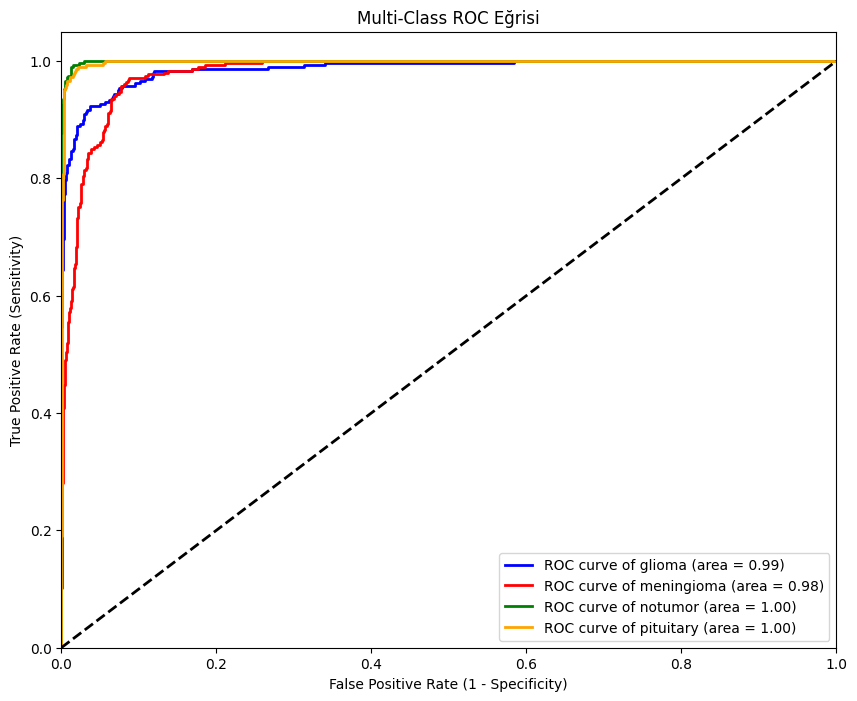


--- Sınıf Bazlı Detaylı Metrikler ---
Sınıf: GLIOMA
  - Sensitivity (Recall): 0.8367
  - Specificity (Özgüllük): 0.9862
------------------------------
Sınıf: MENINGIOMA
  - Sensitivity (Recall): 0.8725
  - Specificity (Özgüllük): 0.9473
------------------------------
Sınıf: NOTUMOR
  - Sensitivity (Recall): 0.9802
  - Specificity (Özgüllük): 0.9868
------------------------------
Sınıf: PITUITARY
  - Sensitivity (Recall): 0.9800
  - Specificity (Özgüllük): 0.9773
------------------------------


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


y_true = test_images.classes
y_pred_probs = model.predict(test_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = list(test_images.class_indices.keys())
n_classes = len(class_names)


y_true_bin = label_binarize(y_true, classes=range(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. ROC Grafiğini Çizme
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Multi-Class ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

# 4. Sensitivity ve Specificity Hesaplama (Confusion Matrix üzerinden)
cm = confusion_matrix(y_true, y_pred)
sensitivity_list = []
specificity_list = []

print("\n--- Sınıf Bazlı Detaylı Metrikler ---")
for i in range(n_classes):
    
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    sensitivity = TP / (TP + FN) if (TP+FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN+FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Sınıf: {class_names[i].upper()}")
    print(f"  - Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  - Specificity (Özgüllük): {specificity:.4f}")
    print("-" * 30)

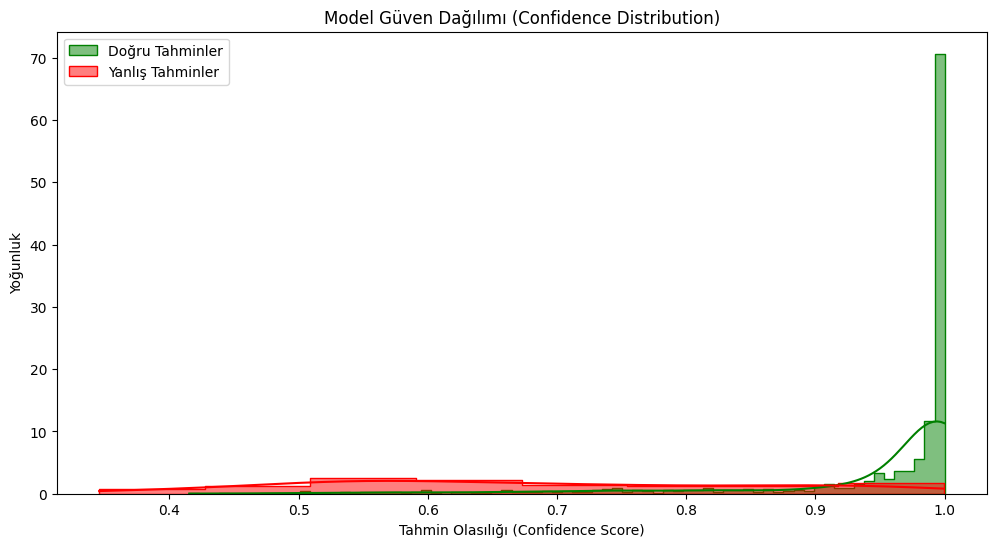

In [ ]:

correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

correct_confidences = np.max(y_pred_probs[correct_indices], axis=1)
incorrect_confidences = np.max(y_pred_probs[incorrect_indices], axis=1)

plt.figure(figsize=(12, 6))


sns.histplot(correct_confidences, color="green", label="Doğru Tahminler", kde=True, element="step", stat="density", alpha=0.5)


sns.histplot(incorrect_confidences, color="red", label="Yanlış Tahminler", kde=True, element="step", stat="density", alpha=0.5)

plt.title("Model Güven Dağılımı (Confidence Distribution)")
plt.xlabel("Tahmin Olasılığı (Confidence Score)")
plt.ylabel("Yoğunluk")
plt.legend()
plt.show()

Toplam Yanlış Sayısı: 102

--- En Yüksek Güvenle Yapılan 5 Hata (Top Losses) ---


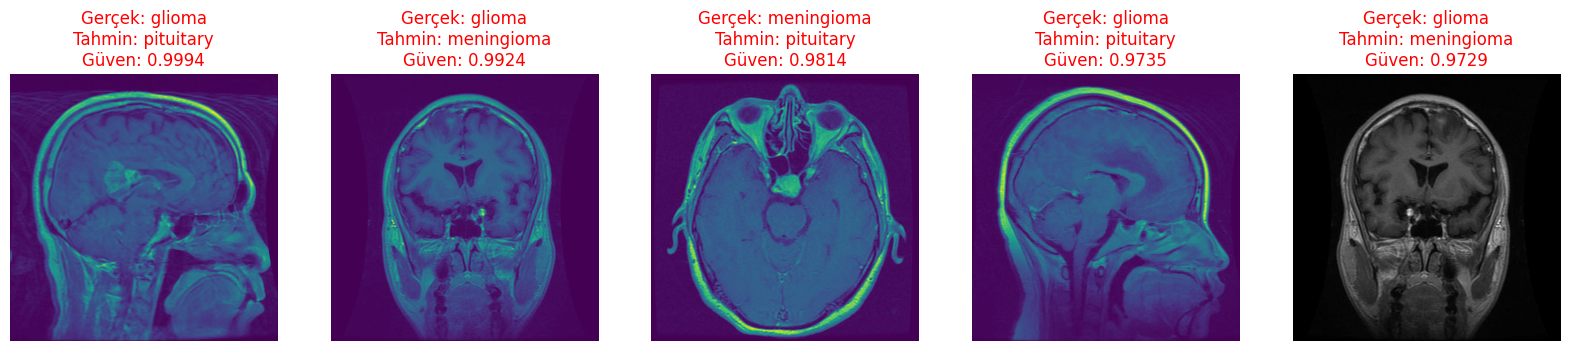

In [ ]:

errors_data = []

for idx in incorrect_indices:
    pred_class_idx = y_pred[idx]
    true_class_idx = y_true[idx]
    confidence = y_pred_probs[idx][pred_class_idx] 
    filepath = test_images.filepaths[idx]

    errors_data.append({
        'index': idx,
        'filepath': filepath,
        'true_label': class_names[true_class_idx],
        'pred_label': class_names[pred_class_idx],
        'confidence': confidence
    })

errors_df = pd.DataFrame(errors_data)

errors_df = errors_df.sort_values(by='confidence', ascending=False)

print(f"Toplam Yanlış Sayısı: {len(errors_df)}")
print("\n--- En Yüksek Güvenle Yapılan 5 Hata (Top Losses) ---")

top_n = 5
if len(errors_df) < top_n: top_n = len(errors_df)

plt.figure(figsize=(20, 10))
for i in range(top_n):
    row = errors_df.iloc[i]
    img = plt.imread(row['filepath'])

    plt.subplot(1, top_n, i+1)
    plt.imshow(img)
    plt.title(f"Gerçek: {row['true_label']}\nTahmin: {row['pred_label']}\nGüven: {row['confidence']:.4f}", color='red')
    plt.axis('off')
plt.show()

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    base_model = model.layers[0]

    classifier_layers = model.layers[1:]

    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    conv_model = tf.keras.Model(inputs=base_model.inputs,
                                outputs=[last_conv_layer.output, base_model.output])

   
    with tf.GradientTape() as tape:
       
        last_conv_layer_output, feature_map = conv_model(img_array)

      
        tape.watch(last_conv_layer_output)
        tape.watch(feature_map)

        
        x = feature_map
        for layer in classifier_layers:
            x = layer(x)


        preds = x

        if pred_index is None:
            pred_index = tf.argmax(preds[0])


        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

   
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

   
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

   
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    return img, superimposed_img




last_conv_layer_name = "top_activation"


correct_sample_indices = random.sample(list(correct_indices), 3)

plt.figure(figsize=(15, 12))
for i, idx in enumerate(correct_sample_indices):
    img_path = test_images.filepaths[idx]


    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    try:
        
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        original, gradcam_img = display_gradcam(img_path, heatmap)


        plt.subplot(3, 2, 2*i + 1)
        plt.imshow(original)
        plt.title(f"Gerçek: {class_names[y_true[idx]]}")
        plt.axis('off')


        plt.subplot(3, 2, 2*i + 2)
        plt.imshow(gradcam_img)
        plt.title(f"Grad-CAM (Odak)")
        plt.axis('off')

    except Exception as e:
        print(f"Index {idx} için hata: {e}")

        import traceback
        traceback.print_exc()

plt.tight_layout()
plt.show()

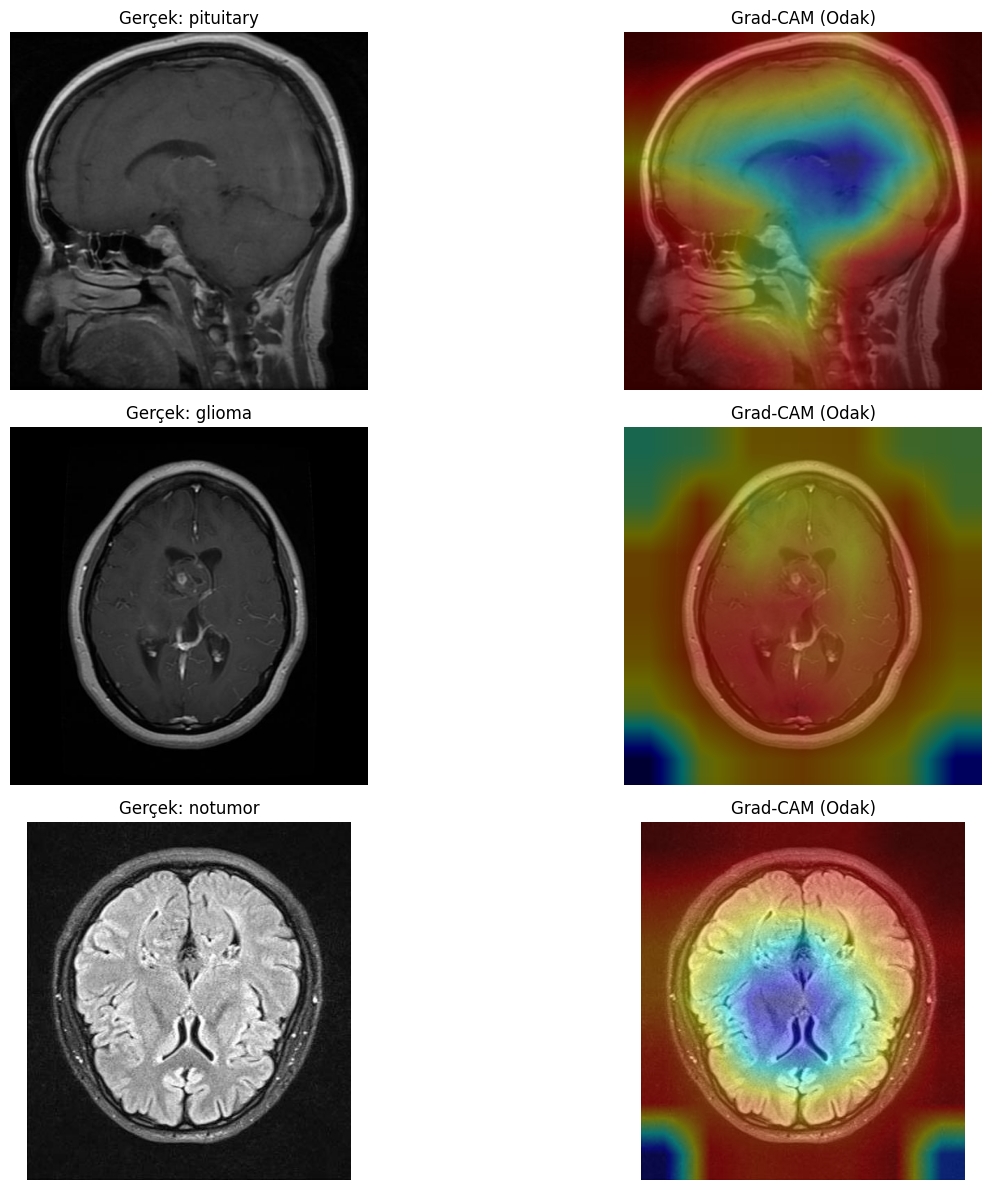